# Solubility prediction

In [1]:
# Import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore

# Set seaborn style as default
sns.set_style()

In [2]:
# Read data
file_path = os.path.join("data", "dataset.csv")
dataset_raw = pd.read_csv(file_path)

## Data overview

In [3]:
# Data Overview
print(dataset_raw.info())
print(50*"-")
print(dataset_raw.nunique())

# Check for missing values
missing_values = dataset_raw.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Check for duplicate entries
duplicate_entries = dataset_raw.duplicated().sum()
print("\nNumber of Duplicate Entries:", duplicate_entries)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9982 non-null   object 
 1   Name                 9982 non-null   object 
 2   InChI                9982 non-null   object 
 3   InChIKey             9982 non-null   object 
 4   SMILES               9982 non-null   object 
 5   Solubility           9982 non-null   float64
 6   SD                   9982 non-null   float64
 7   Ocurrences           9982 non-null   int64  
 8   Group                9982 non-null   object 
 9   MolWt                9982 non-null   float64
 10  MolLogP              9982 non-null   float64
 11  MolMR                9982 non-null   float64
 12  HeavyAtomCount       9982 non-null   float64
 13  NumHAcceptors        9982 non-null   float64
 14  NumHDonors           9982 non-null   float64
 15  NumHeteroatoms       9982 non-null   f

- The dataset consists of 9982 entries with 26 columns, including various chemical descriptors.
- All columns have non-null values, indicating that there are no missing values in the dataset.
- The dataset has no duplicate entries.
- The "Name" column has 89 duplicate entries, suggesting potential discrepancies that may need further investigation.

In [4]:
# Check for duplicates in name column
duplicated_names = dataset_raw[dataset_raw["Name"].duplicated()]["Name"]
duplicated_entries = dataset_raw[dataset_raw["Name"].isin(duplicated_names)]
duplicated_entries.sort_values("Name")

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
15,A-23,"(2E)-3,7-dimethylocta-2,6-dien-1-ol","InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7...",GLZPCOQZEFWAFX-YFHOEESVSA-N,CC(C)=CCC\C(C)=C/CO,-2.320601,0.071633,4,G5,154.253,...,4.0,64.0,0.0,0.0,0.0,0.0,20.23,69.438758,3.544387,150.255712
265,A-447,"(2E)-3,7-dimethylocta-2,6-dien-1-ol","InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7...",GLZPCOQZEFWAFX-JXMROGBWSA-N,CC(C)=CCC\C(C)=C\CO,-2.351910,0.418162,2,G3,154.253,...,4.0,64.0,0.0,0.0,0.0,0.0,20.23,69.438758,3.544387,150.255712
58,A-83,"(2E)-3,7-dimethylocta-2,6-dien-1-yl acetate",InChI=1S/C12H20O2/c1-10(2)6-5-7-11(3)8-9-14-12...,HIGQPQRQIQDZMP-FLIBITNWSA-N,CC(=O)OC\C=C(C)/CCC=C(C)C,-3.754953,0.000000,1,G1,196.290,...,5.0,80.0,0.0,0.0,0.0,0.0,26.30,86.649476,3.670449,232.706284
671,A-1165,"(2E)-3,7-dimethylocta-2,6-dien-1-yl acetate",InChI=1S/C12H20O2/c1-10(2)6-5-7-11(3)8-9-14-12...,HIGQPQRQIQDZMP-DHZHZOJOSA-N,CC(=O)OC/C=C(C)/CCC=C(C)C,-3.830500,0.000000,1,G1,196.290,...,5.0,80.0,0.0,0.0,0.0,0.0,26.30,86.649476,3.670449,232.706284
4482,B-1200,"1,2-dichloropropene","InChI=1S/C3H4Cl2/c1-3(5)2-4/h2H,1H3/b3-2-",PPKPKFIWDXDAGC-IHWYPQMZSA-N,C\C(Cl)=C\Cl,-1.613800,0.000000,1,G1,110.971,...,0.0,30.0,0.0,0.0,0.0,0.0,0.00,41.386065,3.143197,42.854753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7319,C-406,triforine,"InChI=1S/C10H14Cl6N4O2/c11-9(12,13)7(17-5-21)1...",RROQIUMZODEXOR-UHFFFAOYSA-N,ClC(Cl)(Cl)C(NC=O)N1CCN(CC1)C(NC=O)C(Cl)(Cl)Cl,-4.160000,0.015000,2,G3,434.966,...,6.0,128.0,0.0,1.0,1.0,1.0,64.68,157.779932,2.715464,344.593490
6540,B-3527,trovafloxacin,InChI=1S/C20H15F3N4O3/c21-8-1-2-15(13(22)3-8)2...,WVPSKSLAZQPAKQ-SOSAQKQKSA-N,NC1[C@H]2CN(C[C@@H]12)c3nc4N(C=C(C(O)=O)C(=O)c...,-4.529600,0.000000,1,G1,416.359,...,3.0,154.0,3.0,2.0,2.0,5.0,101.45,166.711028,1.761767,1280.507329
8474,C-2554,trovafloxacin,InChI=1S/C20H15F3N4O3/c21-8-1-2-15(13(22)3-8)2...,WVPSKSLAZQPAKQ-UHFFFAOYSA-N,NC1C2CN(CC12)C3=NC4=C(C=C3F)C(=O)C(=CN4C5=CC=C...,-4.530000,0.000000,1,G1,416.359,...,3.0,154.0,3.0,2.0,2.0,5.0,101.45,166.711028,1.761767,1280.507329
7882,C-1685,vamidothion,InChI=1S/C8H18NO4PS2/c1-7(8(10)9-2)15-5-6-16-1...,LESVOLZBIFDZGS-UHFFFAOYSA-N,CNC(=O)C(C)SCCS[P](=O)(OC)OC,0.540000,0.302000,2,G3,287.343,...,8.0,96.0,0.0,0.0,0.0,0.0,64.63,104.690066,3.756993,256.422865


- The dataset contains 177 entries with duplicated names.
- Some entries, like "(2E)-3,7-dimethylocta-2,6-dien-1-ol" and "vamidothion," may describe different stereoisomers or have variations in the position of a methyl group.
- Due to the complexity of identifying proper SMILES representations and minimal differences in resulting chemical descriptors, a decision is made to randomly delete half of the duplicated entries.

In [5]:
# Delete duplicated entries
dataset_unique = dataset_raw.copy().drop_duplicates("Name")

# Check if no duplicates are present
print(dataset_unique.nunique())

ID                     9893
Name                   9893
InChI                  9893
InChIKey               9893
SMILES                 9893
Solubility             7849
SD                     2141
Ocurrences               15
Group                     5
MolWt                  6890
MolLogP                8170
MolMR                  8291
HeavyAtomCount          107
NumHAcceptors            40
NumHDonors               19
NumHeteroatoms           56
NumRotatableBonds        61
NumValenceElectrons     307
NumAromaticRings         16
NumSaturatedRings        14
NumAliphaticRings        14
RingCount                20
TPSA                   2318
LabuteASA              8094
BalabanJ               7020
BertzCT                7591
dtype: int64


Since the reliability groups are simply named G1-G5, their labels can be converted to integers.

In [6]:
# Convert reliability group labels to integers and create a new column "Group_int"
int_groups = dataset_unique["Group"].str.extract("(\d+)").astype(int)
dataset_unique["Group_int"] = int_groups.values
dataset_unique["Group_int"]

0       1
1       1
2       1
3       1
4       1
       ..
9976    3
9977    1
9979    5
9980    1
9981    5
Name: Group_int, Length: 9893, dtype: int64

## Univariate analysis

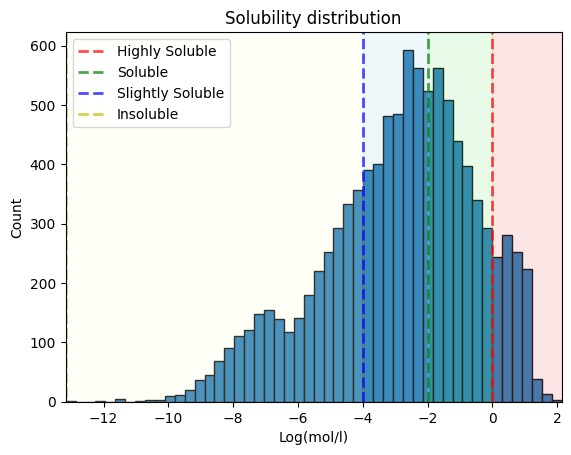

In [7]:
# Group features in different categories
identifiers = ["ID", "Name", "InChl", "InChlKey", "SMILES"]
solubility = "Solubility"
reliability_params = ["SD", "Ocurrences", "Group_int"]
descriptors_2d = ["MolWt", "MolLogP", "MolMR", "HeavyAtomCount",
                  "NumHAcceptors", "NumHDonors", "NumHeteroatoms",
                  "NumRotatableBonds", "NumValenceElectrons",
                  "NumAromaticRings", "NumSaturatedRings",
                  "NumAliphaticRings", "RingCount", "TPSA",
                  "LabuteASA", "BalabanJ", "BertzCT"]
descriptors_sol = descriptors_2d + [solubility]

# Histogram for solubility distribution
dataset_unique[solubility].hist(edgecolor="k", bins=50)
plt.title("Solubility distribution")
plt.xlabel("Log(mol/l)")
plt.ylabel("Count")
plt.grid(False)

# Highlight solubility interpretation ranges with different background colors
x_min = dataset_unique[solubility].min()
x_max = dataset_unique[solubility].max()
plt.axvline(0, color='r', linestyle='dashed', linewidth=2, label='Highly Soluble', alpha=0.7)
plt.axvspan(0, x_max, color='lightcoral', alpha=0.2)
plt.axvline(-2, color='g', linestyle='dashed', linewidth=2, label='Soluble', alpha=0.7)
plt.axvspan(-2, 0, color='lightgreen', alpha=0.2)
plt.axvline(-4, color='b', linestyle='dashed', linewidth=2, label='Slightly Soluble', alpha=0.7)
plt.axvspan(-4, -2, color='lightblue', alpha=0.2)
plt.axvline(x_min, -4, color='y', linestyle='dashed', linewidth=2, label='Insoluble', alpha=0.7)
plt.axvspan(x_min, -4, color='lightyellow', alpha=0.2)
plt.xlim(x_min, x_max)

plt.legend()
plt.show()

- Solubility values appear to be concentrated within -6 and 2, with a peak around -2.
- According to the paper the LogS can be interpreted as:
  - Highly soluble >= 0
  - Soluble [0, -2]
  - Slightly soluble [-2, -4]
  - Insoluble < -4

In [8]:
# Checking standard statistics for solubility
dataset_unique[solubility].describe()

count    9893.000000
mean       -2.887359
std         2.371803
min       -13.171900
25%        -4.323800
50%        -2.602500
75%        -1.204700
max         2.137682
Name: Solubility, dtype: float64

- The mean solubility is approximately -2.89.
- The standard deviation is approximately 2.37.
- The interquartile range (IQR) indicates that 50% of the solubility values fall between approximately -4.32 and -1.20.
- The solubility distribution is slightly left-skewed
- The range is extensive, with highly soluble compounds ranging up to a maximum of 2.14 logS, while very insoluble compounds range to a minimum of -13.17.
- Considering that values below -4 are regarded as insoluble, it may make sense to limit or handle these negative outliers in further analysis.

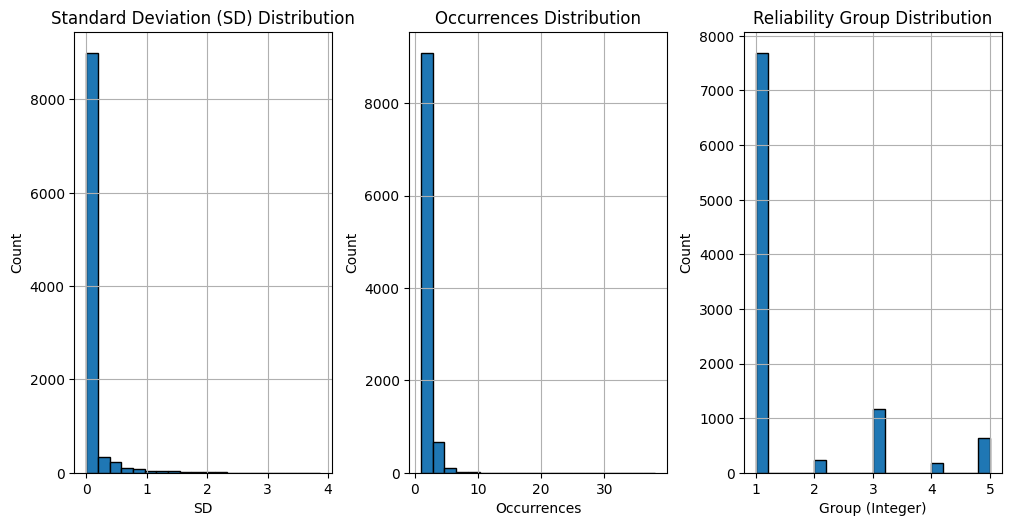

In [9]:
# Histograms for reliability parameters
fix, ax = plt.subplots(1,3, figsize=(10,5))
plt.tight_layout()
dataset_unique[reliability_params].hist(edgecolor="k", bins=20, ax=ax)

# Set plot titles and labels
ax[0].set_title("Standard Deviation (SD) Distribution")
ax[0].set_xlabel("SD")
ax[0].set_ylabel("Count")

ax[1].set_title("Occurrences Distribution")
ax[1].set_xlabel("Occurrences")
ax[1].set_ylabel("Count")

ax[2].set_title("Reliability Group Distribution")
ax[2].set_xlabel("Group (Integer)")
ax[2].set_ylabel("Count")

plt.show()

- The vast majority of entries have a **standard deviation** of 0 since they only occured 1 time in all underlying datasets. This is also reflected by the vast majority of compounds found in **Group 1** which is per definition every compound found only once in the original datasets.

                      count        mean         std        min         25%  \
MolWt                9893.0  266.239977  184.608696   9.012000  162.229000   
MolLogP              9893.0    1.976471    3.527169 -40.873200    0.607600   
MolMR                9893.0   66.663320   46.627735   0.000000   40.531000   
HeavyAtomCount       9893.0   17.337006   12.263519   1.000000   11.000000   
NumHAcceptors        9893.0    3.478015    3.503283   0.000000    2.000000   
NumHDonors           9893.0    1.105529    1.485808   0.000000    0.000000   
NumHeteroatoms       9893.0    5.193571    4.747574   0.000000    3.000000   
NumRotatableBonds    9893.0    4.079854    5.667129   0.000000    1.000000   
NumValenceElectrons  9893.0   94.038714   64.854969   0.000000   58.000000   
NumAromaticRings     9893.0    1.069948    1.312311   0.000000    0.000000   
NumSaturatedRings    9893.0    0.284140    0.867616   0.000000    0.000000   
NumAliphaticRings    9893.0    0.435257    1.037011   0.000000  

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


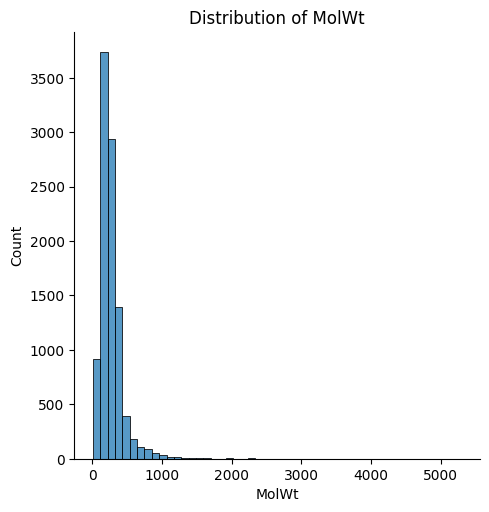

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


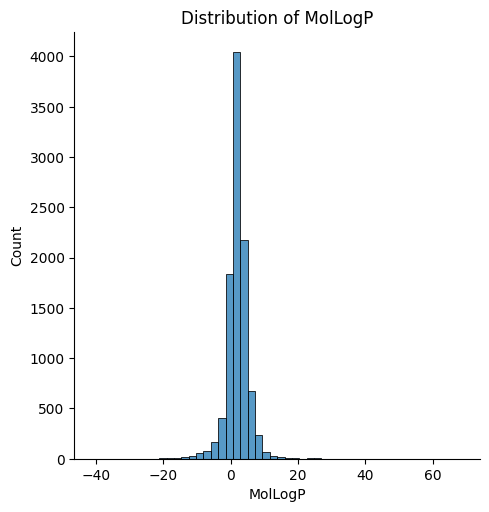

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


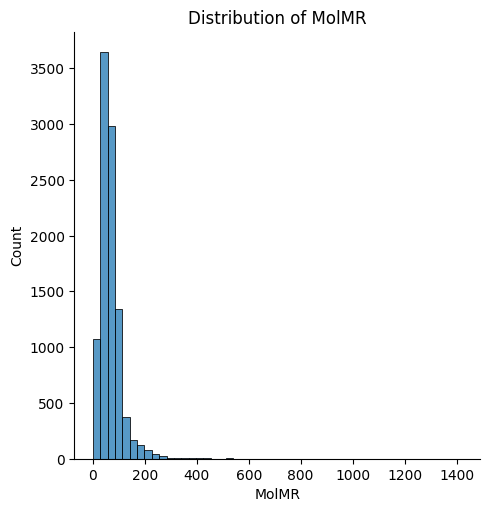

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


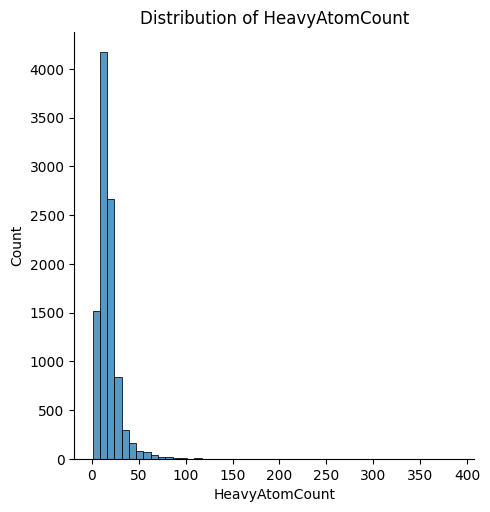

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


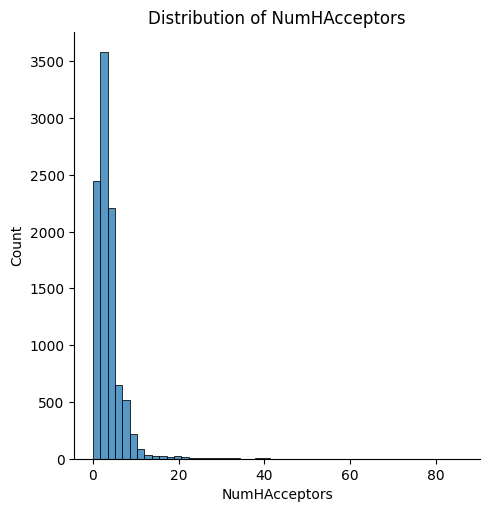

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


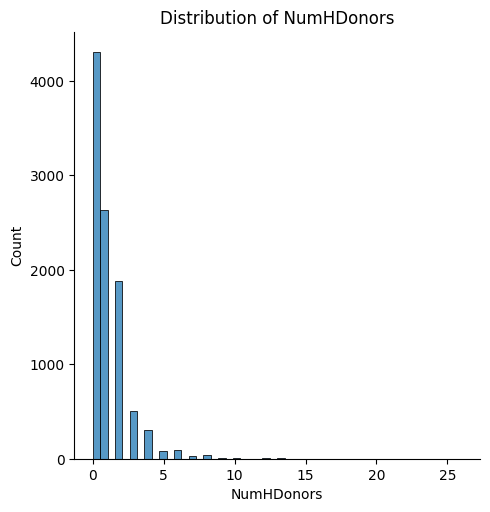

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


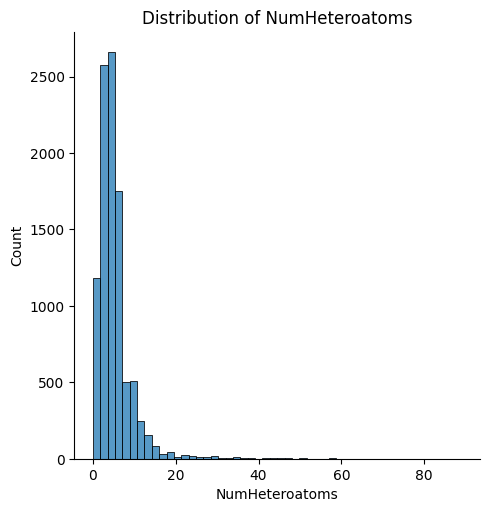

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


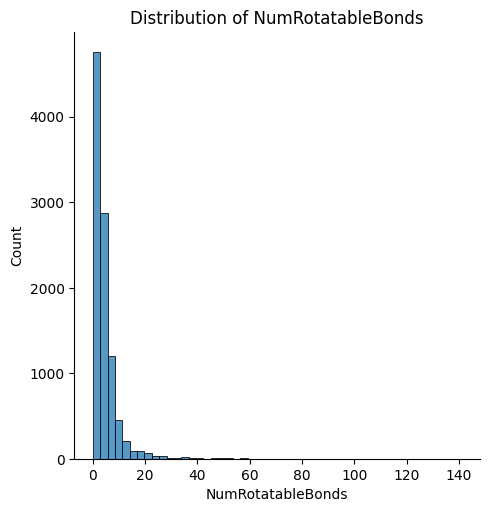

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


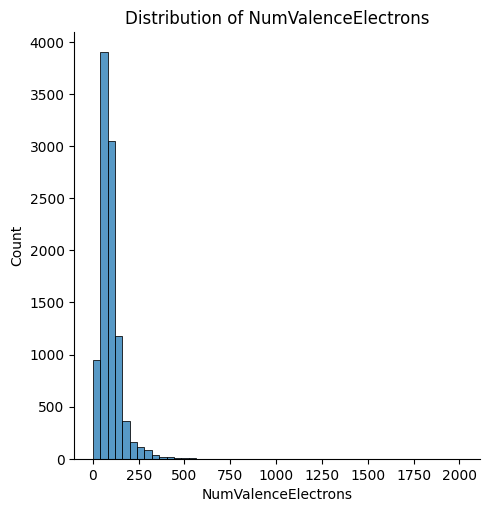

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


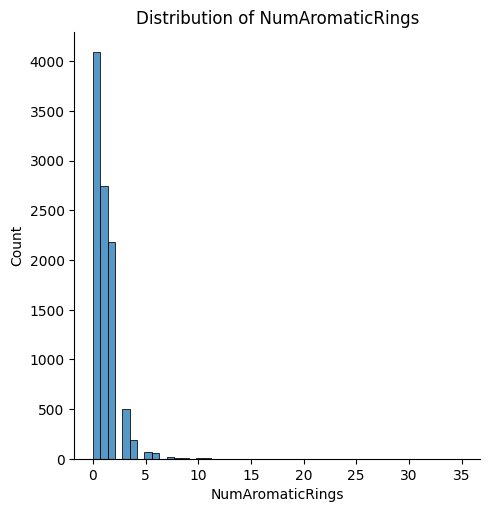

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


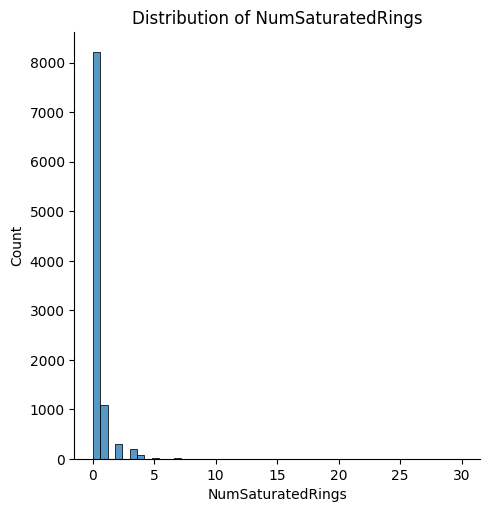

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


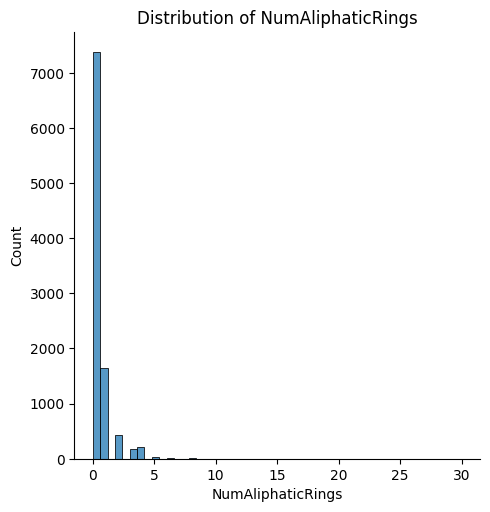

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


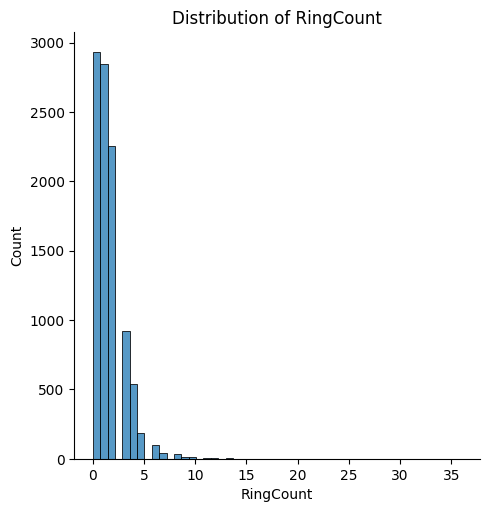

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


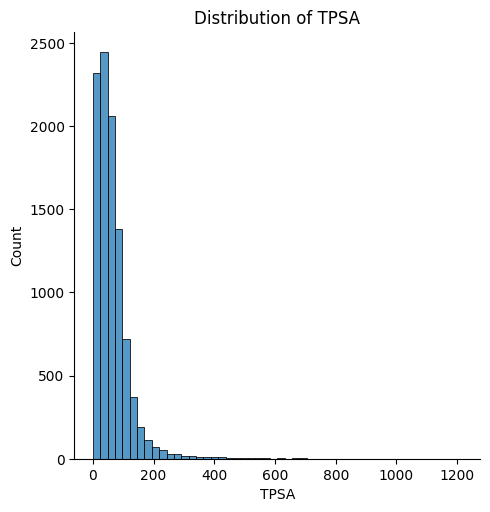

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


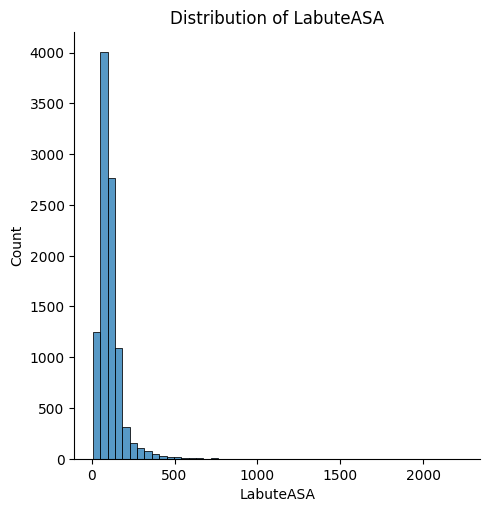

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


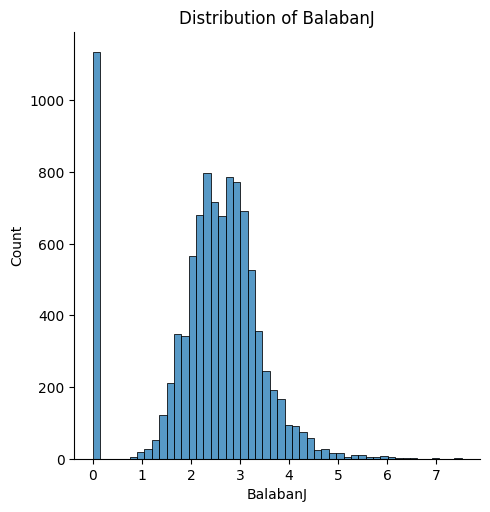

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


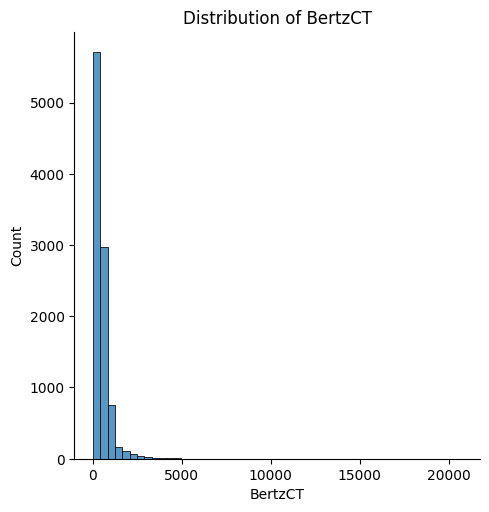

In [10]:
# Descriptive statistics for chemical descriptors
print(dataset_unique[descriptors_2d].describe().transpose())

# Histograms for chemical descriptors
for descriptor in descriptors_2d:
    sns.displot(data=dataset_unique, x=descriptor, bins=50)
    plt.title(f"Distribution of {descriptor}")
    plt.xlabel(descriptor)
    plt.ylabel("Count")
    plt.show()

**Molecular Weight (MolWt):**

- Mean MolWt: The average molecular weight is approximately 266.24 g/mol.
- Minimum and Maximum: Molecular weights range from 9.01 g/mol to 5299.46 g/mol.

**LogP (MolLogP):**

- Mean LogP: The average LogP is around 1.98.
- Minimum and Maximum: LogP values range from -40.87 to 68.54.

**Molecular Refractivity (MolMR):**

- Mean MolMR: The average molecular refractivity is approximately 66.66.
- Minimum and Maximum: Molecular refractivity values range from 0 to 1419.35.

**Heavy Atom Count (HeavyAtomCount):**

- Mean HeavyAtomCount: The average count of heavy atoms is approximately 17.34.
- Minimum and Maximum: Heavy atom counts range from 1 to 388.

**Balaban J Index and Bertz CT:**

- The Balaban J index shows a remarkable normal distribution, but there is a portion of entries with very low index values.
- Similar observations are made for Bertz CT.

**Ring Count Descriptors:**

- The number of aliphatic, aromatic, and saturated rings is predominantly 0 for most entries.
- Consider transforming these features into binary indicators (presence or absence of rings) for a potentially more meaningful representation.

**Other Descriptors:**

- Similar statistics are provided for other descriptors such as the number of hydrogen acceptors, hydrogen donors, heteroatoms, rotatable bonds, valence electrons, aromatic rings, saturated rings, aliphatic rings, ring count, TPSA, LabuteASA, BalabanJ, and BertzCT.

**Trends:**
- Chemical descriptors are generally skewed, and some exhibit outliers to the right.
- There is a minority of larger molecules (e.i., MolWt) that may automatically be classified as outliers in features related to hydrogen bonds, surface areas, etc.

#### Conclusions univariate analysis:

1. **Removing Very Big Molecules:**
  - Considering the presence of very big molecules, it's reasonable to remove them, especially since their rarity could lead to skewed distributions in various features.

2. **Transforming Ring Descriptors:**
  - Converting the descriptors related to the number of rings into categorical features after removing the big molecules could provide a more meaningful representation of the data.

3. **Transforming Solubility Scores:**
  - Transforming solubility scores into categories can enhance the interpretability of the data and may align with the practical interpretation of solubility levels.

## Bivariate analysis

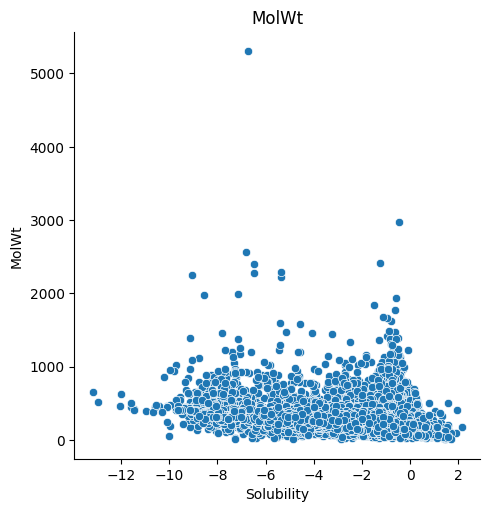

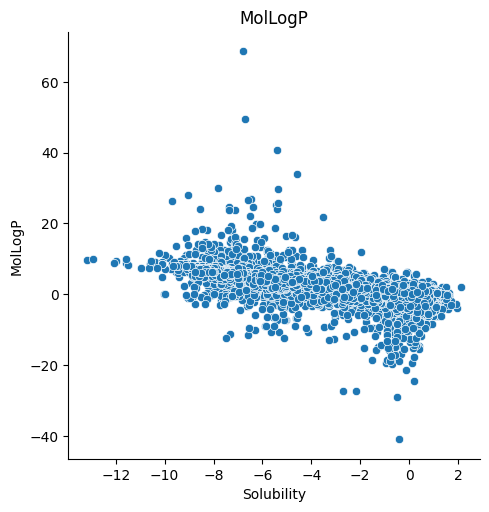

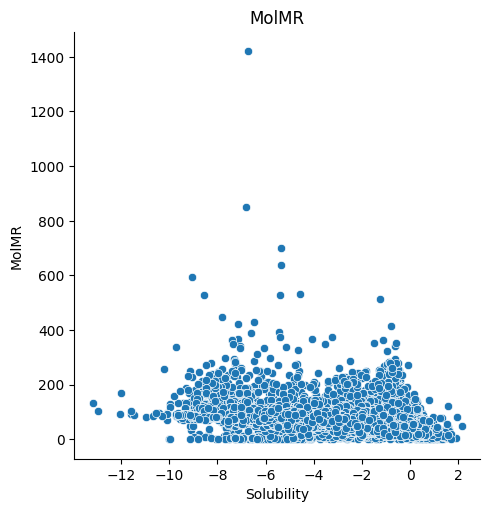

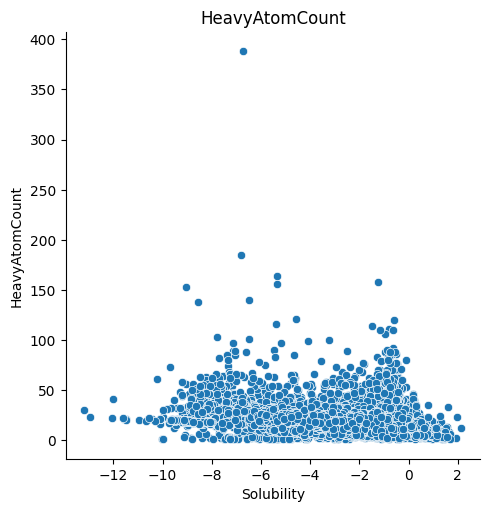

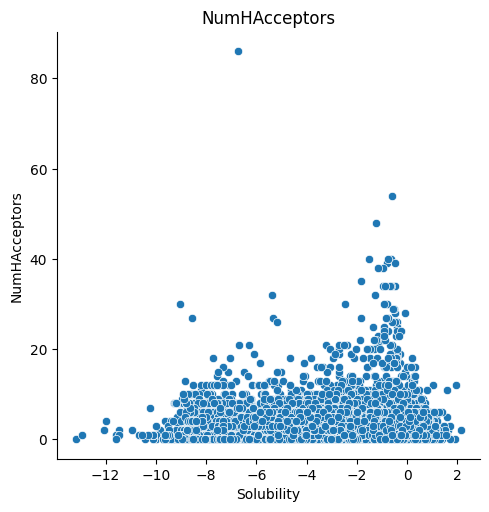

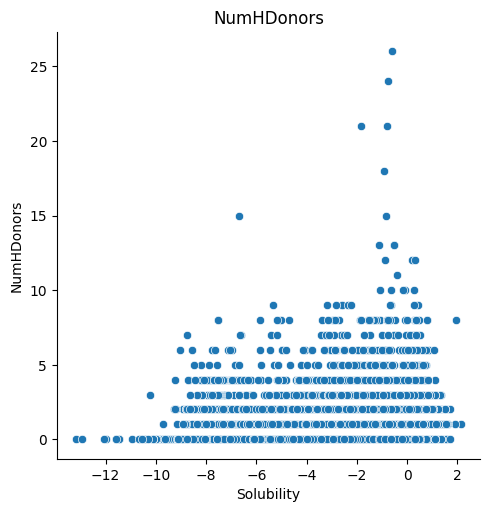

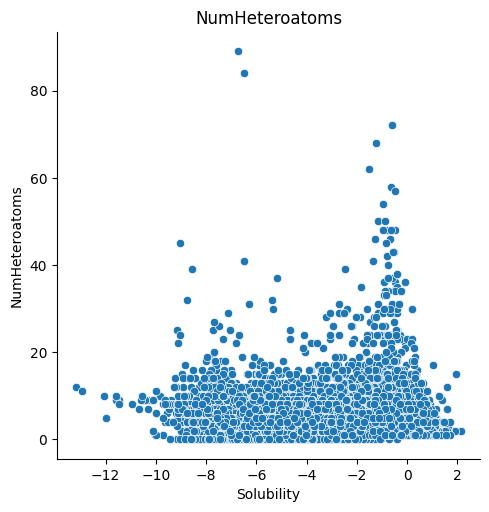

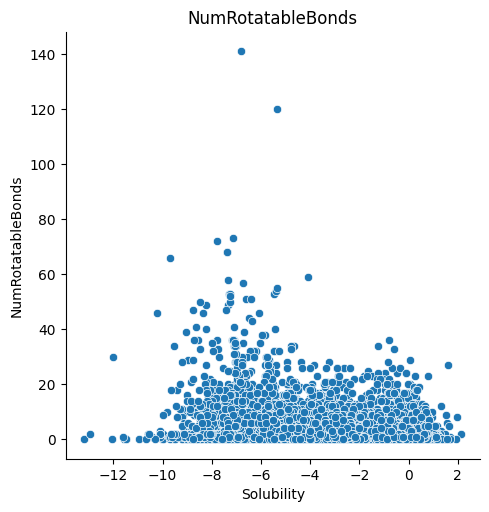

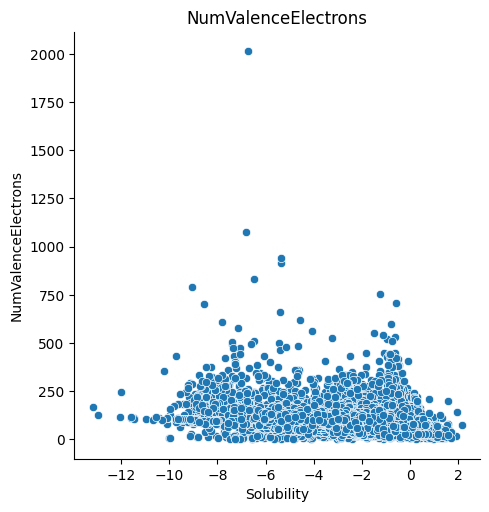

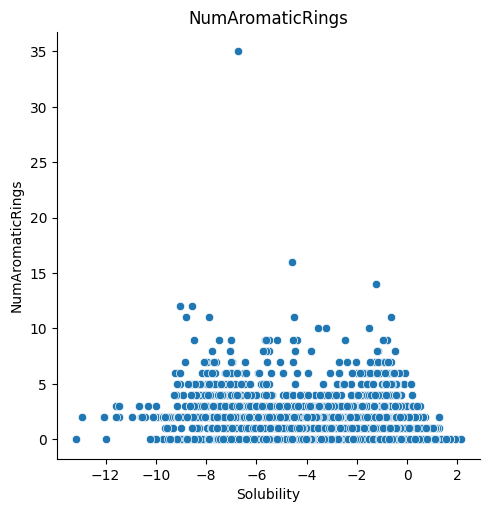

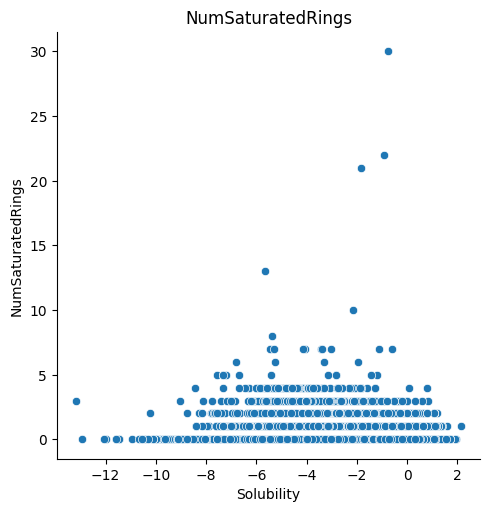

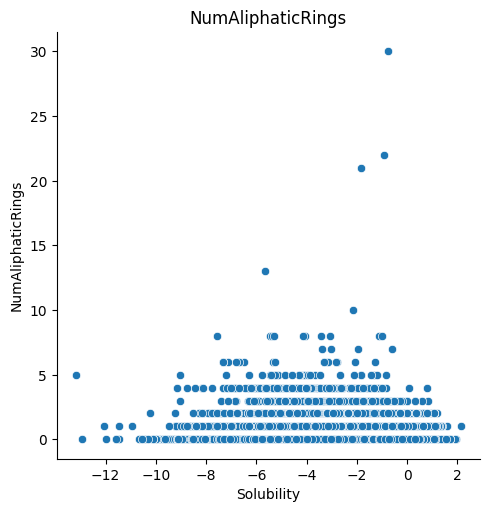

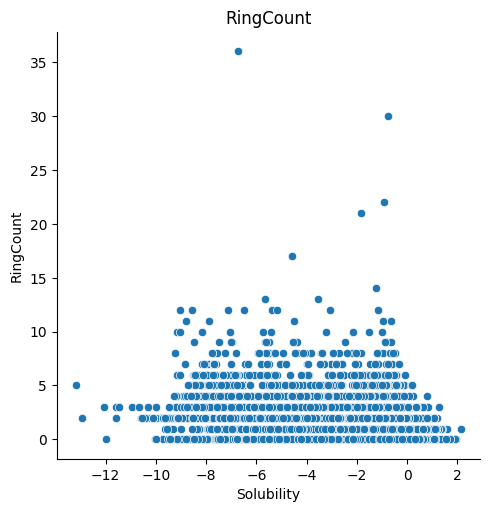

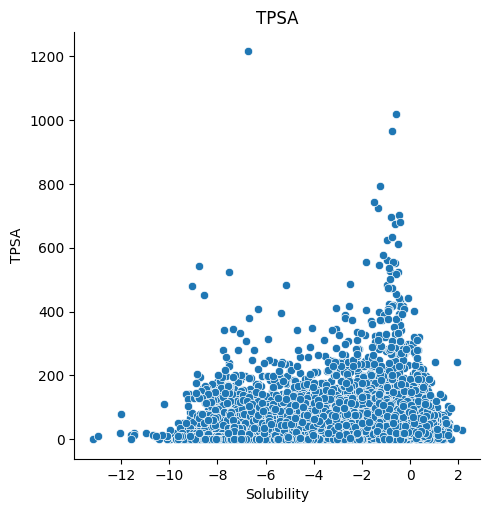

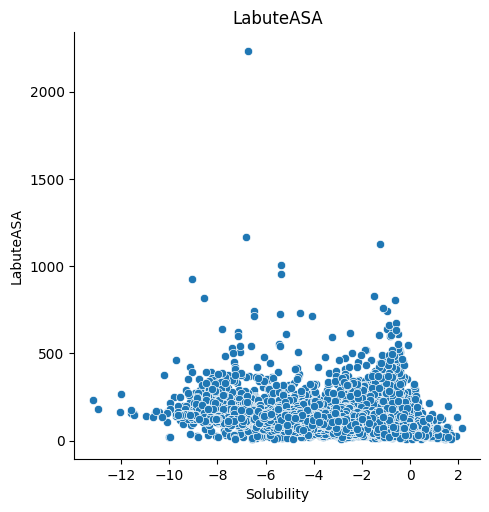

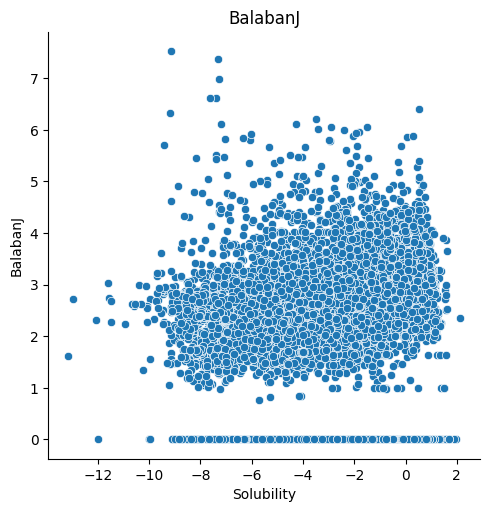

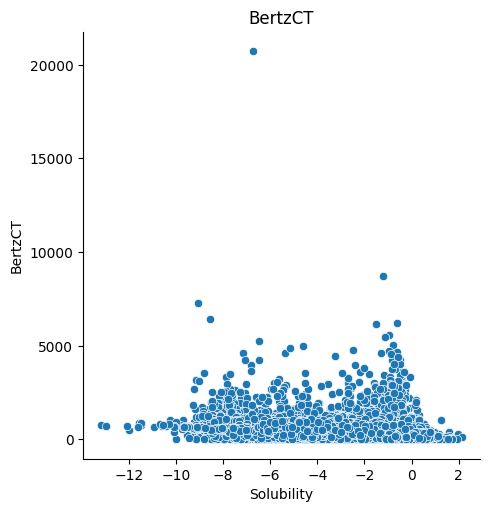

In [11]:
# Scatter different descriptors against solubility
for descriptor in descriptors_2d:
  sns.relplot(data=dataset_unique, x=solubility, y=descriptor)
  plt.title(str(descriptor))
  plt.show()

Solubility             1.000000
MolLogP                0.608359
MolMR                  0.423887
MolWt                  0.367340
HeavyAtomCount         0.351972
LabuteASA              0.348720
NumValenceElectrons    0.345719
NumAromaticRings       0.343367
RingCount              0.329181
BertzCT                0.288205
NumRotatableBonds      0.222832
NumHDonors             0.193529
TPSA                   0.112467
NumAliphaticRings      0.085846
NumHAcceptors          0.040676
NumHeteroatoms         0.039729
BalabanJ               0.036077
NumSaturatedRings      0.035092
Name: Solubility, dtype: float64


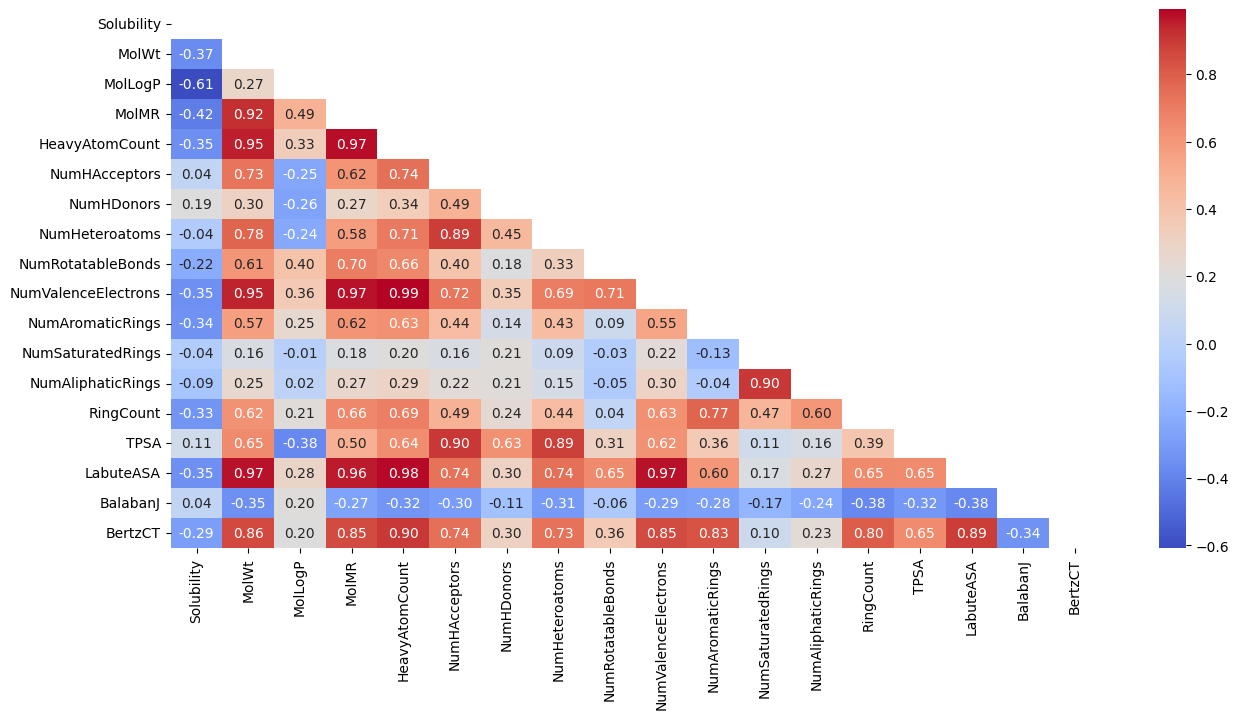

In [13]:
# Calculate correlation matrix
corr_matr = dataset_unique.corr(numeric_only=True)
# Drop reliability features from matrix
corr_matr = corr_matr.drop(columns=reliability_params).drop(reliability_params,
                                                            axis=0)
# Print pearson correlation coefficients
print(corr_matr["Solubility"].abs().sort_values(ascending=False))

# Prepare mask for correlation matrix
mask = np.triu(np.ones_like(corr_matr))

# Draw correlation matrix
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr_matr, annot=True, cmap="coolwarm",
            fmt=".2f", ax=ax, linecolor="black", mask=mask)
plt.show()

- The most influencing features for aqueous solubility are:

  - MolLogP                0.61
  - MolMR                  0.42
  - MolWt                  0.37
  - HeavyAtomCount         0.35
  - LabuteASA              0.35
  - NumValenceElectrons    0.35
  - NumAromaticRings       0.34
  - RingCount              0.33


- The logarithm of the partition coefficient between n-octanol and water is not very surprising since it measures the hydrophobicity of a compound.

- The Balaban J index is the less influential feature.

## Outlier detection

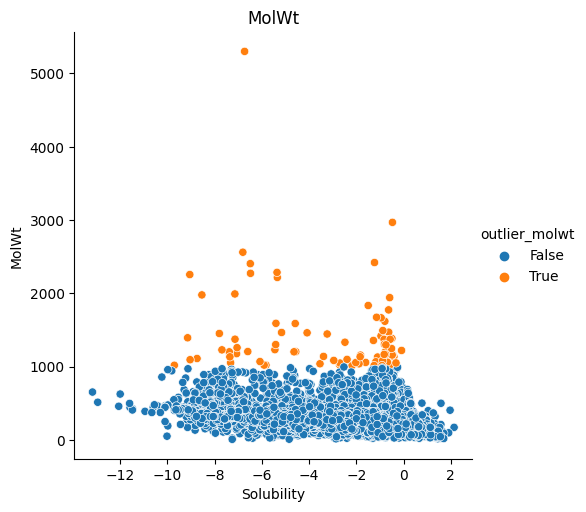

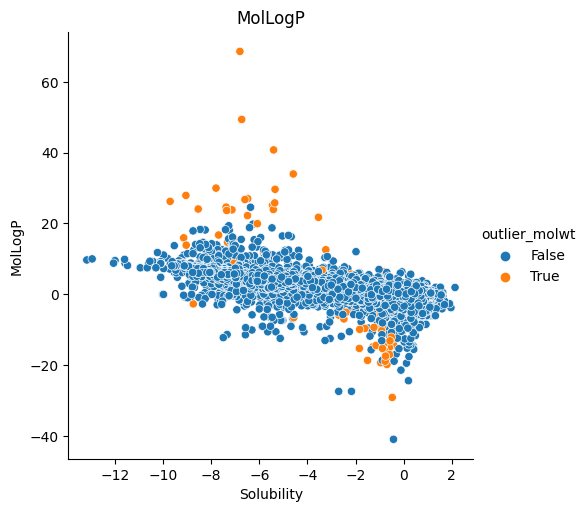

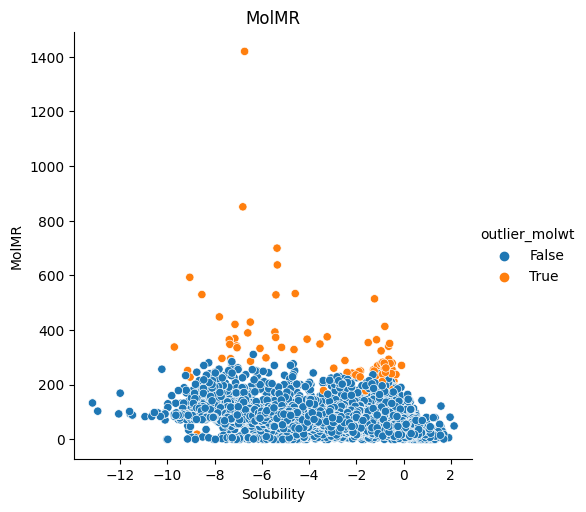

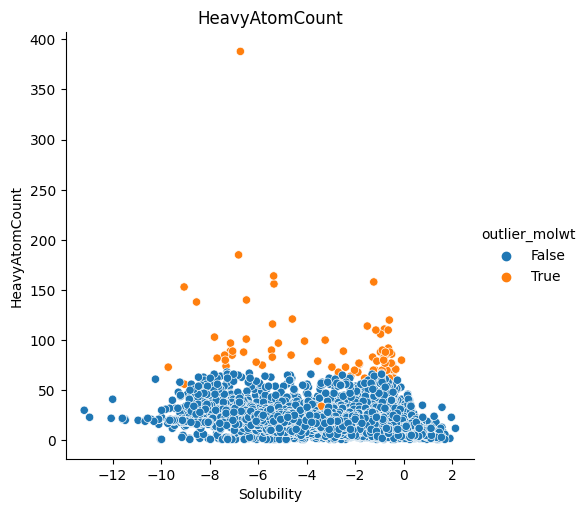

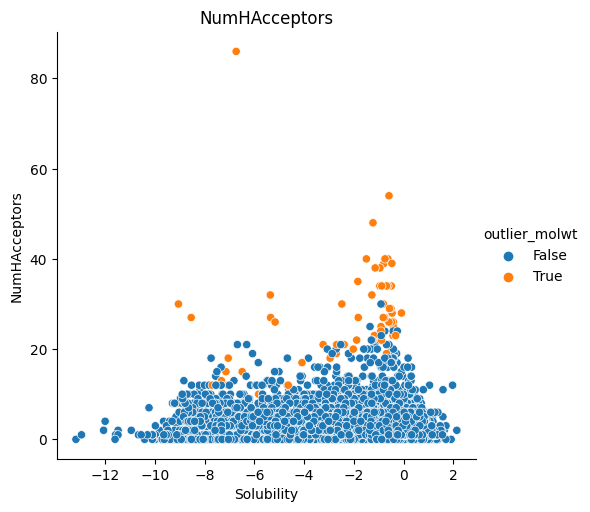

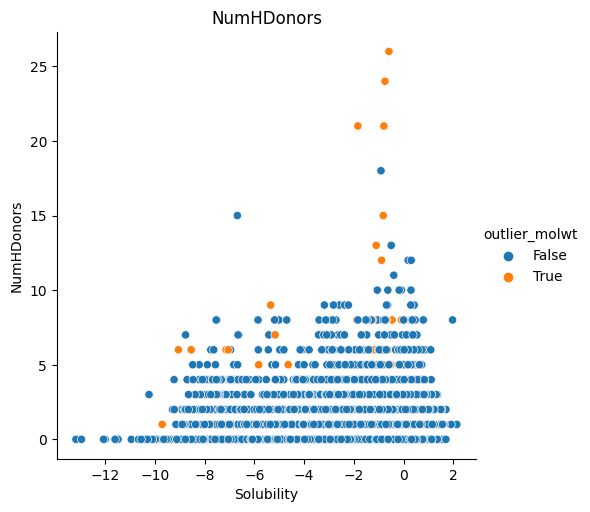

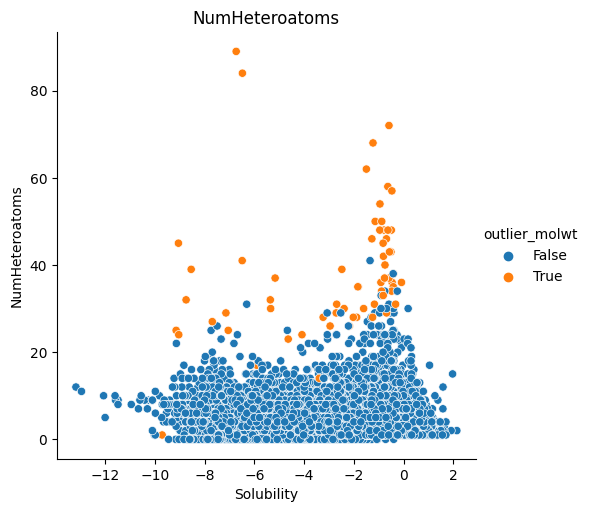

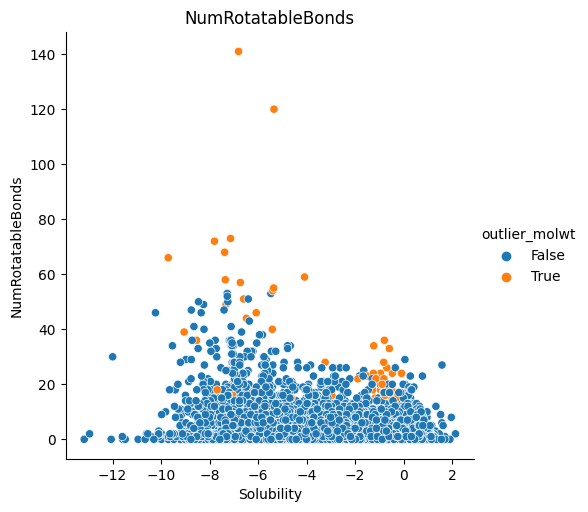

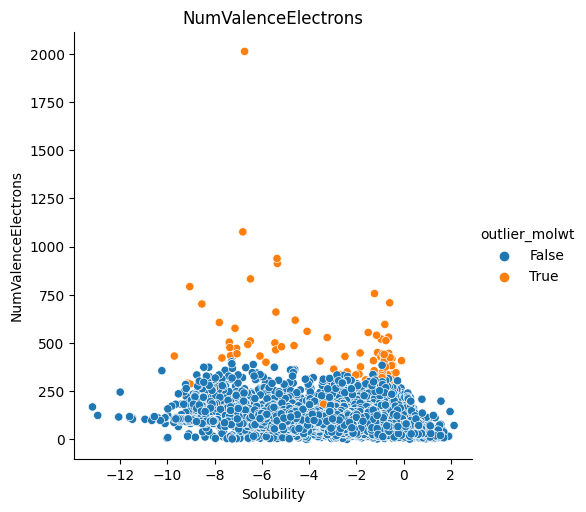

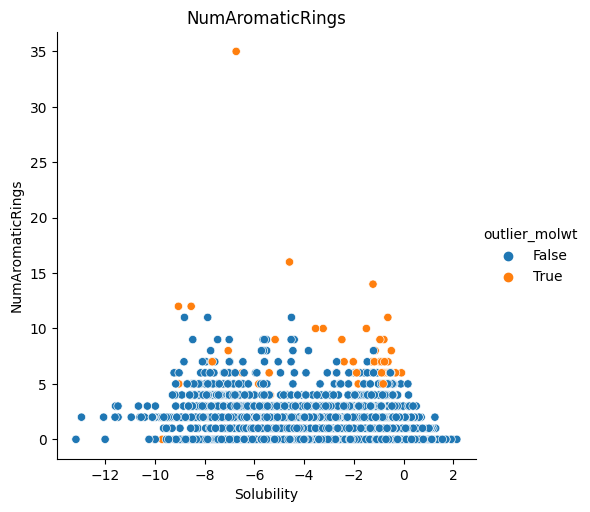

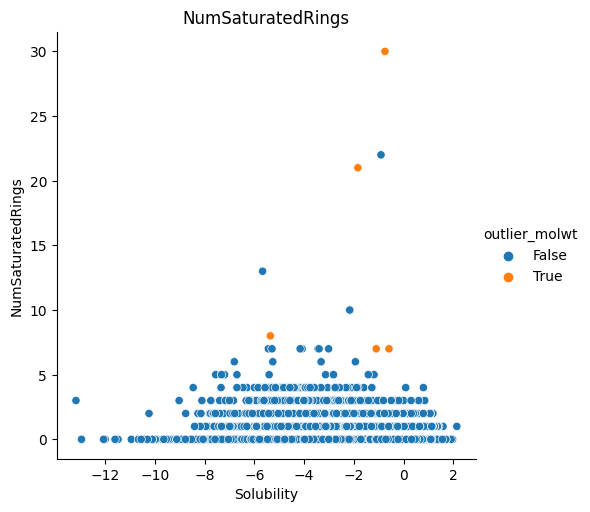

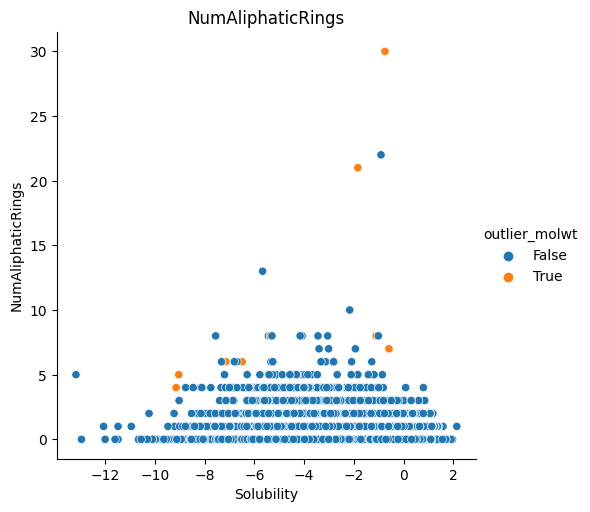

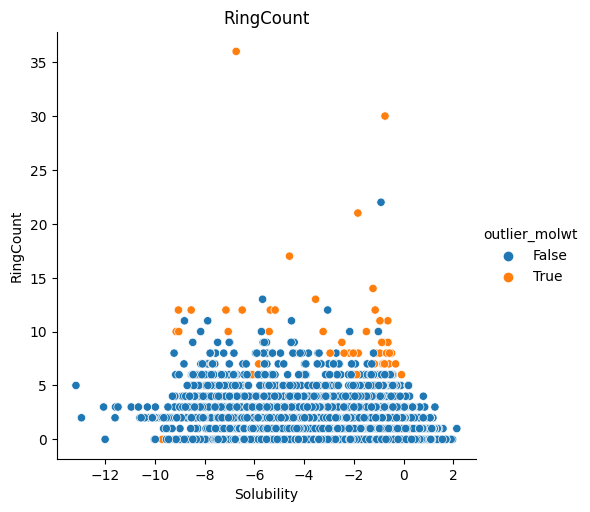

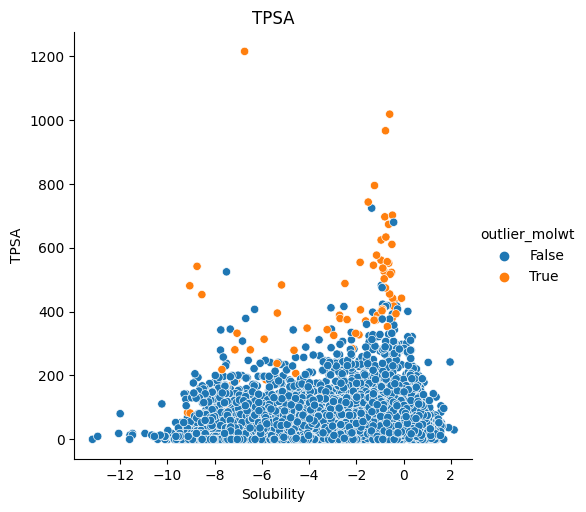

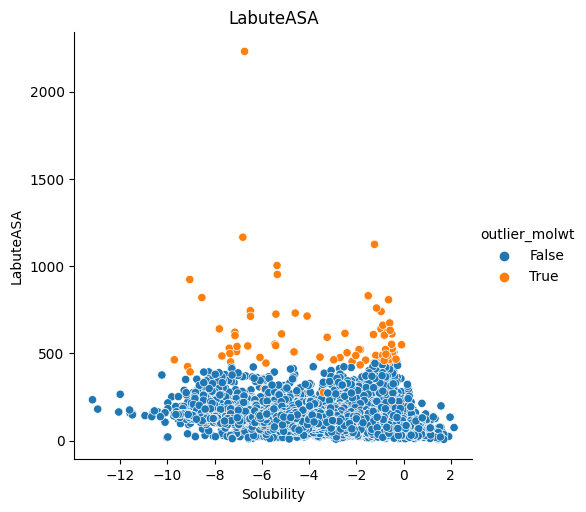

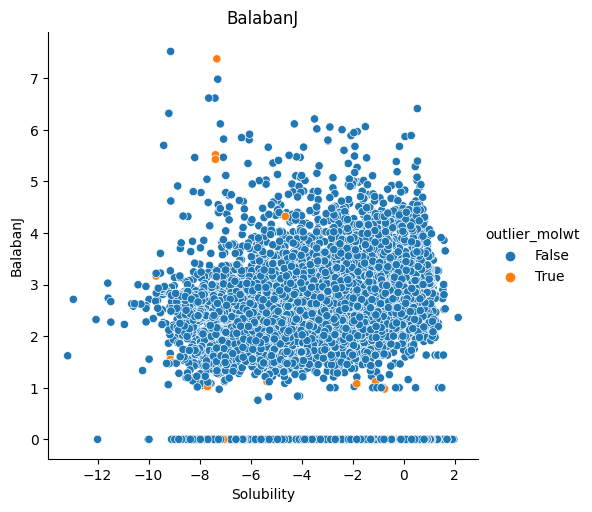

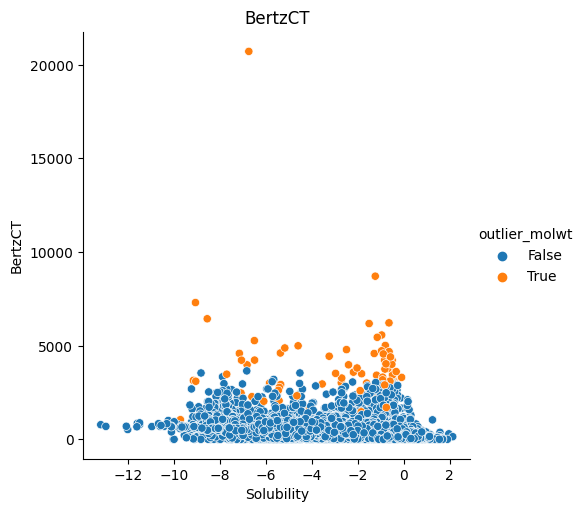

In [14]:
# Calculate z-scores for molecular weight
z_molwt = zscore(dataset_unique["MolWt"])

# Define outliers as entries with 4 std away from mean
outliers_molwt = abs(z_molwt > 4)

# Save outlier as binary column in dataframe
dataset_outliers = dataset_unique.copy()
dataset_outliers["outlier_molwt"] = outliers_molwt

# Scatter different descriptors against molecular weight
for descriptor in descriptors_2d:
  sns.relplot(data=dataset_outliers, x=solubility, y=descriptor, hue="outlier_molwt")
  plt.title(str(descriptor))
  plt.show()

In [15]:
# Check how many instances are outliers
number_outliers = len(dataset_outliers.query("outlier_molwt == True"))
print(f" Outliers: {number_outliers}")

# Check what is the smalles molecule in the outlier group
smallest_outlier = dataset_outliers.query("outlier_molwt == True").loc[:, "MolWt"].min()
print(f" Smallest outlier: {smallest_outlier}")

 Outliers: 85
 Smallest outlier: 1006.703


- Outliers are defined as entries with z-scores greater than 4 standard deviations from the mean.
- There are 85 instances identified as outliers.
- The smallest molecule in the outlier group has a molecular weight of 1006.703.
- As expected, very large molecules heavily influence most other chemical descriptors.
- Interestingly, the outliers are not the most extreme molecules with regard to solubility, but with regard to other features like the partition coefficient LogP.
- Since the smallest outlier is roughly 1000 Da big, a cutoff for molecular weight is introduced, filtering out all molecules that are bigger than 1000 Da.

## Data preprocessing and feature engineering

**Filter out big molecules and categorize ring features**

In [16]:
# Filter out molecules with a molecular weight greater than 1000 Da
dataset_filtered = dataset_unique.copy()
dataset_filtered = dataset_filtered.query("MolWt < 1000")

# Turn ring features into categorical features
# Set to True when they have at least 1 ring in the corresponding category
dataset_engineered = dataset_filtered.copy()

# Iterate through ring-related columns and create new categorical columns
for col in ["RingCount", "NumAromaticRings", "NumAliphaticRings", "NumSaturatedRings"]:
    dataset_engineered[col + "_cat"] = dataset_engineered[col] >= 1

**Solubility values are categorized into different bins**

In [17]:
# Categorize solubility into different bins
bins_sol = [-float("inf"), -4, -2, 0, float("inf")]
labels = ["Insoluble", "Slightly soluble", "Soluble", "Highly soluble"]

# Create a new categorical column "Solubility_cat" based on binning
dataset_engineered["Solubility_cat"] =  pd.cut(dataset_engineered["Solubility"],
                                               bins=bins_sol,
                                               labels=labels)

# Turn categorical labels into integers using LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the Solubility_cat column to obtain encoded values
encoded_sol = label_encoder.fit_transform(dataset_engineered["Solubility_cat"])
# Add a new column "Solubility_enc" with the encoded solubility values
dataset_engineered["Solubility_enc"] = encoded_sol

**Save processed dataset**

In [19]:
# Save the processed dataframe to use in model screening
file_path = os.path.join("data", "dataset_processed.csv")
dataset_engineered.to_csv(file_path, index=False)